Best parameters: {'alpha': 0.1, 'l1_ratio': 0.5}
MSE: 322.0340547383613, R²: 0.7255328023071224


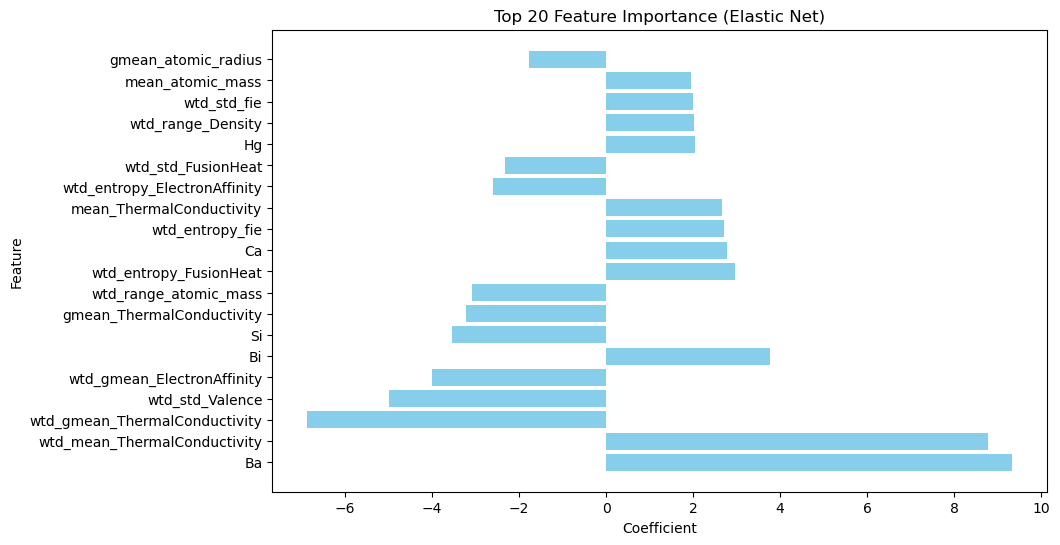

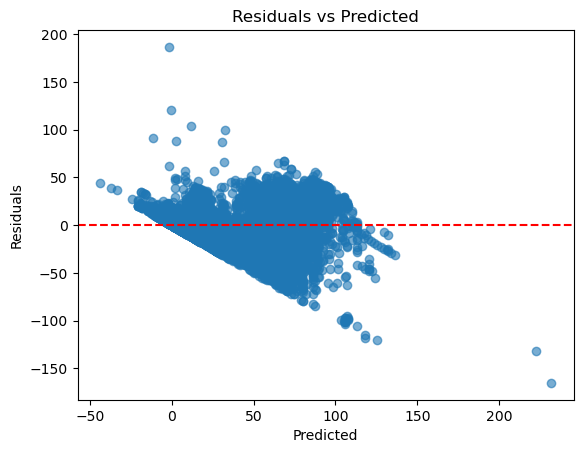

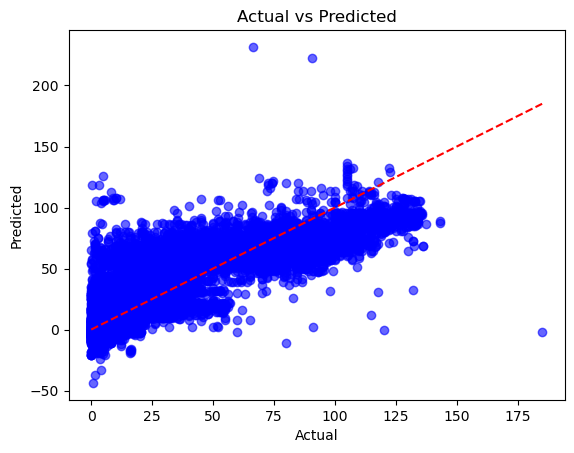

Mean CV MSE: 366.657897004657


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load datasets
train_data = pd.read_csv("train.csv")
metadata = pd.read_csv("unique_m.csv")

# Merge datasets
metadata = metadata.drop(columns=["critical_temp", "material"])
combined_data = pd.merge(train_data, metadata, left_index=True, right_index=True)

# Handle multicollinearity
correlation_matrix = combined_data.corr().abs()
high_correlation = correlation_matrix[correlation_matrix > 0.95].stack().reset_index()
to_drop = set(high_correlation.loc[high_correlation['level_0'] != high_correlation['level_1'], 'level_1'])
combined_data = combined_data.drop(columns=to_drop)

# Separate target and features
X = combined_data.drop(columns=["critical_temp"])
y = combined_data["critical_temp"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Elastic Net hyperparameter tuning
elastic_net = ElasticNet()
param_grid = {
    "alpha": [0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.5, 0.9]
}
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_scaled, y)

# Best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate
y_pred = best_model.predict(X_scaled)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"MSE: {mse}, R²: {r2}")


import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": best_model.coef_
})
coefficients["Abs_Coefficient"] = np.abs(coefficients["Coefficient"])
coefficients = coefficients.sort_values(by="Abs_Coefficient", ascending=False).head(20)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(coefficients["Feature"], coefficients["Coefficient"], color="skyblue")
plt.title("Top 20 Feature Importance (Elastic Net)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()


# Residuals
residuals = y - y_pred

# Residual plot
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

# Actual vs Predicted
plt.scatter(y, y_pred, alpha=0.6, color="blue")
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Cross-validate Elastic Net
cv_scores = cross_val_score(best_model, X_scaled, y, cv=10, scoring="neg_mean_squared_error")
print(f"Mean CV MSE: {-np.mean(cv_scores)}")



Best Alpha: 0.03162277660168379
Best L1 Ratio: 0.8217171717171717
Test MAE: 12.729173654349895


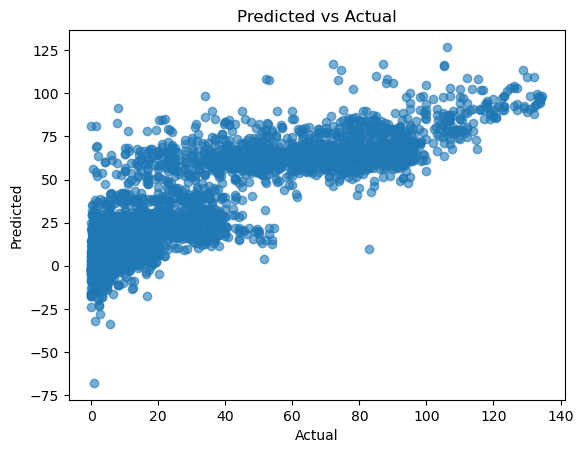

In [9]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and combine datasets
data_train = pd.read_csv("train.csv")
data_elements = pd.read_csv("unique_m.csv")
data_combined = data_train.join(data_elements.drop(columns=["critical_temp", "material"]))

# Drop highly correlated features
correlation_matrix = data_combined.corr()
high_corr = correlation_matrix[correlation_matrix.abs() > 0.95].stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
data_combined = data_combined.drop(columns=high_corr['level_1'].unique())

# Split data
X = data_combined.drop(columns=["critical_temp"])
y = data_combined["critical_temp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid
param_grid = {
    "alpha": np.logspace(-5, 2, 9),  # Regularization strength
    "l1_ratio": np.linspace(0.01, 0.99, 100),  # Mixing parameter
}

# GridSearchCV with ElasticNet
elastic_net = ElasticNet(max_iter=10000, random_state=42)
grid_search = GridSearchCV(elastic_net, param_grid, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Alpha:", best_params["alpha"])
print("Best L1 Ratio:", best_params["l1_ratio"])

# Predictions
y_pred = best_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)

# Plot Predictions vs Actual
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
data_train = pd.read_csv("train.csv")
data_elements = pd.read_csv("unique_m.csv")

# Merge datasets
data_elements = data_elements.drop(columns=["critical_temp", "material"])
data_combined = data_train.join(data_elements)

# Drop highly correlated features
correlation_matrix = data_combined.corr()
high_corr_vars = correlation_matrix.columns[(correlation_matrix.abs() > 0.95).sum() > 1]
data_combined = data_combined.drop(columns=high_corr_vars)

# Split data into features and target
X = data_combined.drop(columns=["critical_temp"])
y = data_combined["critical_temp"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Elastic Net with cross-validation
elastic_net = ElasticNetCV(l1_ratio=np.linspace(0.01, 0.99, 100), alphas=np.logspace(-5, 2, 9),
                           cv=5, random_state=42)
elastic_net.fit(X_train_scaled, y_train)

# Results
y_pred = elastic_net.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Elastic Net Results: MAE={mae:.4f}, MSE={mse:.4f}, R²={r2:.4f}")
print(f"Optimal alpha: {elastic_net.alpha_}, Optimal l1_ratio: {elastic_net.l1_ratio_}")

# Feature importance
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": elastic_net.coef_
})
coefficients["Abs_Coefficient"] = coefficients["Coefficient"].abs()
coefficients = coefficients.sort_values(by="Abs_Coefficient", ascending=False)

top_20_features = coefficients.head(20)
print("Top 20 Features:")
print(top_20_features)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(data=top_20_features, y="Feature", x="Abs_Coefficient", palette="viridis")
plt.title("Top 20 Feature Importances (Elastic Net)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Residuals Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Log Transformation for Target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

elastic_net_log = ElasticNetCV(l1_ratio=np.linspace(0.01, 0.99, 100), alphas=np.logspace(-5, 2, 9),
                               cv=5, random_state=42)
elastic_net_log.fit(X_train_scaled, y_train_log)

# Elastic Net with cross-validation
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 0.99, 100),
    alphas=np.logspace(-5, 2, 9),
    cv=5,
    random_state=42,
    max_iter=5000  # Increase the number of iterations
)
elastic_net.fit(X_train_scaled, y_train)


# Log-transformed Results
y_pred_log = elastic_net_log.predict(X_test_scaled)
residuals_log = y_test_log - y_pred_log

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_log, residuals_log, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted (Log-transformed)")
plt.xlabel("Fitted Values (Log-transformed)")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Effect of regularization strength on MAE
alphas = np.logspace(-5, 2, 9)
mae_scores = []
for alpha in alphas:
    model = ElasticNet(alpha=alpha, l1_ratio=elastic_net.l1_ratio_, random_state=42)
    model.fit(X_train_scaled, y_train_log)
    preds = model.predict(X_test_scaled)
    mae_scores.append(mean_absolute_error(y_test_log, preds))

plt.figure(figsize=(10, 6))
plt.plot(alphas, mae_scores, marker="o")
plt.xscale("log")
plt.title("Effect of Regularization Strength on MAE (Log-transformed Target)")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Metrics
print(f"Log-transformed Elastic Net Results: MAE={min(mae_scores):.4f}, Alpha={alphas[np.argmin(mae_scores)]}")


- Elastic Net Results: MAE=12.9517, MSE=303.4943, R²=0.7363
     -Optimal alpha: 0.23713737056616552, Optimal l1_ratio: 0.99
    - Top 20 Features:
                             - Feature  Coefficient  Abs_Coefficient
                             
                            - 31      wtd_mean_ThermalConductivity    14.821066        14.821066
                            - 33     wtd_gmean_ThermalConductivity   -12.310227        12.310227
                            - 94                                Ba     9.527773         9.527773
                            - 121                               Bi     4.282131         4.282131
                            - 38                   wtd_std_Valence    -4.102071         4.102071
                            - 19        wtd_gmean_ElectronAffinity    -3.528191         3.528191
                            - 27            wtd_entropy_FusionHeat     3.492710         3.492710
                            - 52                                Si    -3.124068         3.124068
                            - 35   wtd_entropy_ThermalConductivity     2.658297         2.658297
                            - 2              wtd_range_atomic_mass    -2.534717         2.534717
                            - 58                                Ca     2.323330         2.323330
                            - 118                               Hg     2.219596         2.219596
                            - 21      wtd_entropy_ElectronAffinity    -2.138540         2.138540
                            - 6                        wtd_std_fie     2.029457         2.029457
                            - 8                gmean_atomic_radius    -1.775203         1.775203
                            - 29                wtd_std_FusionHeat    -1.715338         1.715338
                            - 119                               Tl     1.471322         1.471322
                            - 76                                Sr     1.317020         1.317020
                            - 85                                Ag    -1.194370         1.194370
                            - 5                      wtd_range_fie     1.098569         1.098569

In [12]:
# Ensure both X and y are scaled
y_train_scaled = StandardScaler().fit_transform(y_train.values.reshape(-1, 1)).ravel()


In [13]:
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.1, 0.9, 10),  # Narrow down the range
    alphas=np.logspace(-3, 1, 10),       # Focus on plausible values
    cv=5,
    random_state=42,
    max_iter=10000,                      # Further increase max iterations
    tol=1e-3                             # Adjust tolerance for convergence
)


In [14]:
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.1, 0.9, 10),
    alphas=np.logspace(-3, 1, 10),
    cv=5,
    random_state=42,
    max_iter=10000,
    tol=1e-3,
    verbose=1  # Detailed logs
)
elastic_net.fit(X_train_scaled, y_train_scaled)


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.9s
..........

ElasticNetCV(alphas=array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01]),
             cv=5,
             l1_ratio=array([0.1       , 0.18888889, 0.27777778, 0.36666667, 0.45555556,
       0.54444444, 0.63333333, 0.72222222, 0.81111111, 0.9       ]),
             max_iter=10000, random_state=42, tol=0.001, verbose=1)

In [15]:
elastic_net.fit(X_train_scaled[:500], y_train_scaled[:500])


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
..........

ElasticNetCV(alphas=array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01]),
             cv=5,
             l1_ratio=array([0.1       , 0.18888889, 0.27777778, 0.36666667, 0.45555556,
       0.54444444, 0.63333333, 0.72222222, 0.81111111, 0.9       ]),
             max_iter=10000, random_state=42, tol=0.001, verbose=1)

In [16]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': np.logspace(-3, 1, 10),
    'l1_ratio': np.linspace(0.1, 0.9, 10)
}

elastic_net = ElasticNet(max_iter=10000, tol=1e-3)
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train_scaled)

# Best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)


{'alpha': np.float64(0.0027825594022071257), 'l1_ratio': np.float64(0.7222222222222222)}
-0.3848868967961555


In [17]:
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 0.99, 100),
    alphas=np.logspace(-5, 2, 9),
    cv=5,
    random_state=42,
    max_iter=50_000,
    tol=1e-4
)


In [18]:
elastic_net = ElasticNet(max_iter=50_000, warm_start=True, random_state=42)


In [19]:
from scipy.optimize import minimize


Elastic Net Results (Original Target): MAE=12.9517, MSE=303.4943, R²=0.7363
Optimal alpha: 0.23713737056616552, Optimal l1_ratio: 0.99
Elastic Net Results (Log-transformed Target): MAE=0.4905, MSE=0.4109, R²=0.7540
Optimal alpha (Log-transformed): 0.004216965034285823, Optimal l1_ratio (Log-transformed): 0.99
Top 20 Features (Original Target):
                             Feature  Coefficient (Original)  \
31      wtd_mean_ThermalConductivity               14.821066   
33     wtd_gmean_ThermalConductivity              -12.310227   
94                                Ba                9.527773   
121                               Bi                4.282131   
38                   wtd_std_Valence               -4.102071   
19        wtd_gmean_ElectronAffinity               -3.528191   
27            wtd_entropy_FusionHeat                3.492710   
52                                Si               -3.124068   
35   wtd_entropy_ThermalConductivity                2.658297   
2             

C:\Users\jessi\AppData\Local\Temp\ipykernel_8200\4052897622.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, y="Feature", x="Abs_Coefficient_Original", palette="viridis")


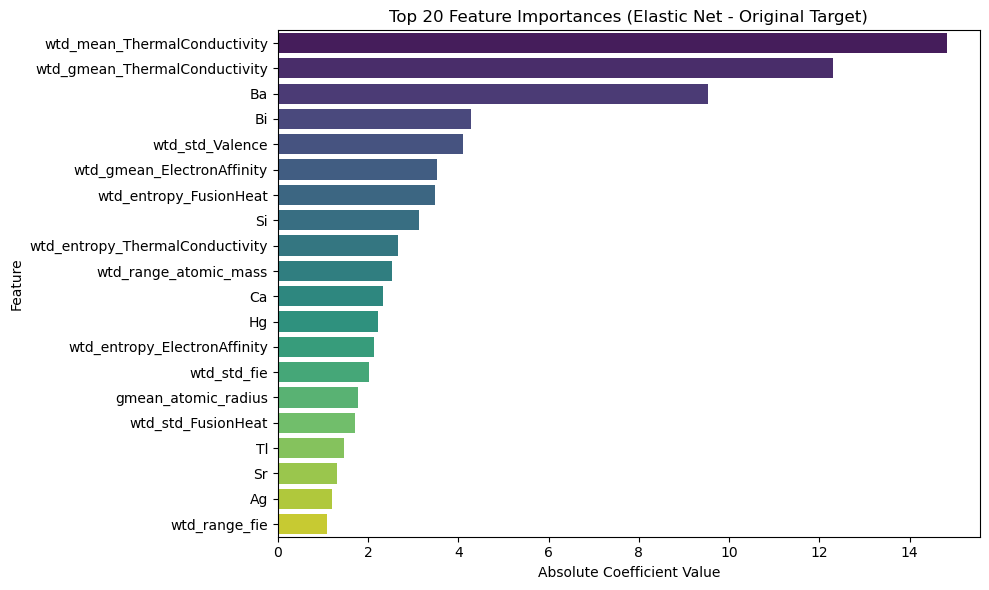

C:\Users\jessi\AppData\Local\Temp\ipykernel_8200\4052897622.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features_log, y="Feature", x="Abs_Coefficient_Log", palette="mako")


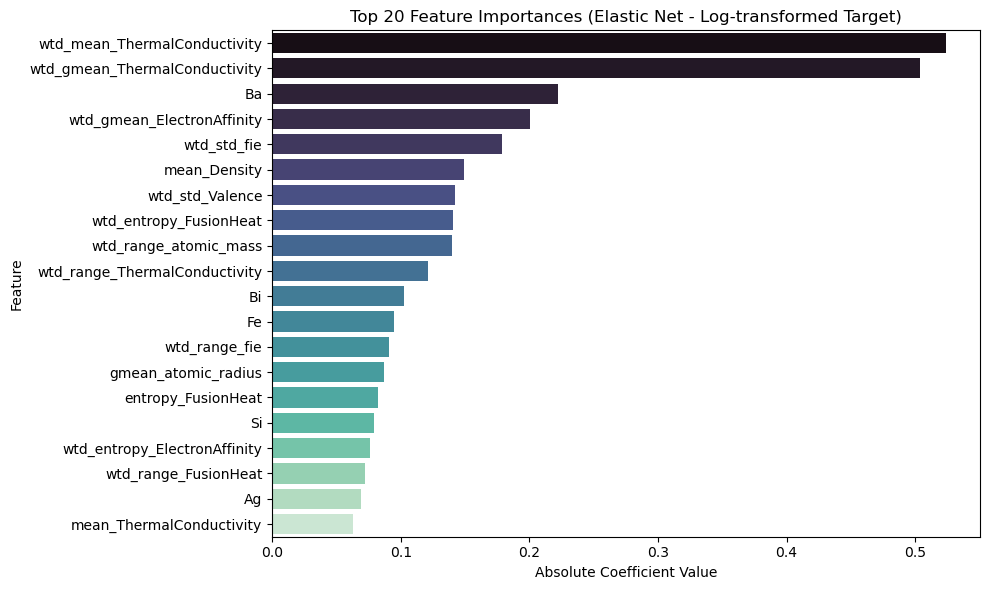

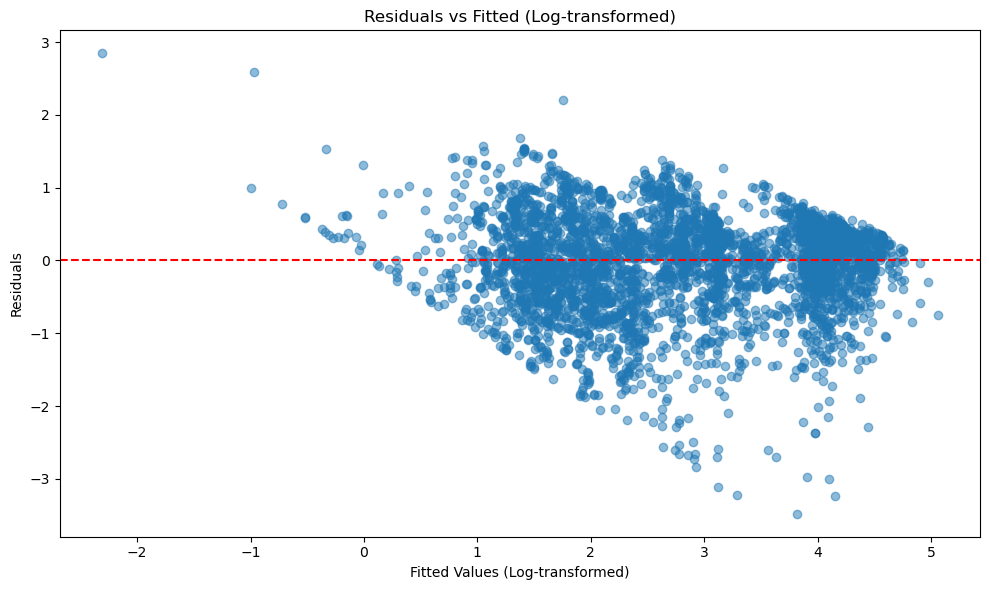

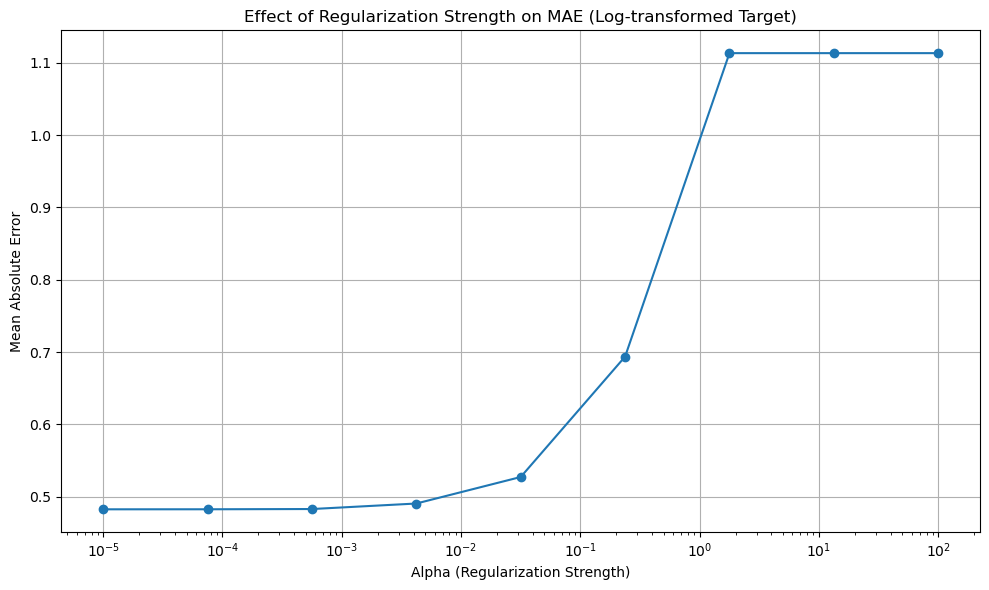

Best Regularization Strength (Log-transformed): Alpha=1e-05, MAE=0.4825


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
data_train = pd.read_csv("train.csv")
data_elements = pd.read_csv("unique_m.csv")

# Merge datasets
data_elements = data_elements.drop(columns=["critical_temp", "material"])
data_combined = data_train.join(data_elements)

# Drop highly correlated features
correlation_matrix = data_combined.corr()
high_corr_vars = correlation_matrix.columns[(correlation_matrix.abs() > 0.95).sum() > 1]
data_combined = data_combined.drop(columns=high_corr_vars)

# Split data into features and target
X = data_combined.drop(columns=["critical_temp"])
y = data_combined["critical_temp"]

# Log-transform the target variable
y_log = np.log1p(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_log_scaled = scaler.fit_transform(X_train_log)
X_test_log_scaled = scaler.transform(X_test_log)

# Elastic Net with cross-validation (non-transformed target)
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 0.99, 100),
    alphas=np.logspace(-5, 2, 9),
    cv=5,
    random_state=42,
    max_iter=50_000,
    tol=1e-4
)
elastic_net.fit(X_train_scaled, y_train)

# Results for non-transformed target
y_pred = elastic_net.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Elastic Net Results (Original Target): MAE={mae:.4f}, MSE={mse:.4f}, R²={r2:.4f}")
print(f"Optimal alpha: {elastic_net.alpha_}, Optimal l1_ratio: {elastic_net.l1_ratio_}")

# Elastic Net with cross-validation (log-transformed target)
elastic_net_log = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 0.99, 100),
    alphas=np.logspace(-5, 2, 9),
    cv=5,
    random_state=42,
    max_iter=50_000,
    tol=1e-4
)
elastic_net_log.fit(X_train_log_scaled, y_train_log)

# Results for log-transformed target
y_pred_log = elastic_net_log.predict(X_test_log_scaled)
mae_log = mean_absolute_error(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)

print(f"Elastic Net Results (Log-transformed Target): MAE={mae_log:.4f}, MSE={mse_log:.4f}, R²={r2_log:.4f}")
print(f"Optimal alpha (Log-transformed): {elastic_net_log.alpha_}, Optimal l1_ratio (Log-transformed): {elastic_net_log.l1_ratio_}")

# Feature Importance
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient (Original)": elastic_net.coef_,
    "Coefficient (Log-transformed)": elastic_net_log.coef_
})
coefficients["Abs_Coefficient_Original"] = coefficients["Coefficient (Original)"].abs()
coefficients["Abs_Coefficient_Log"] = coefficients["Coefficient (Log-transformed)"].abs()

# Top 20 features
top_20_features = coefficients.sort_values(by="Abs_Coefficient_Original", ascending=False).head(20)
print("Top 20 Features (Original Target):")
print(top_20_features)

# Plot top 20 features (Original Target)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_20_features, y="Feature", x="Abs_Coefficient_Original", palette="viridis")
plt.title("Top 20 Feature Importances (Elastic Net - Original Target)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Plot top 20 features (Log-transformed Target)
top_20_features_log = coefficients.sort_values(by="Abs_Coefficient_Log", ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_20_features_log, y="Feature", x="Abs_Coefficient_Log", palette="mako")
plt.title("Top 20 Feature Importances (Elastic Net - Log-transformed Target)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Residuals Analysis (Log-transformed)
residuals_log = y_test_log - y_pred_log
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_log, residuals_log, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted (Log-transformed)")
plt.xlabel("Fitted Values (Log-transformed)")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Effect of Regularization Strength (Log-transformed)
alphas = np.logspace(-5, 2, 9)
mae_scores = []
for alpha in alphas:
    model = ElasticNet(alpha=alpha, l1_ratio=elastic_net_log.l1_ratio_, random_state=42)
    model.fit(X_train_log_scaled, y_train_log)
    preds = model.predict(X_test_log_scaled)
    mae_scores.append(mean_absolute_error(y_test_log, preds))

plt.figure(figsize=(10, 6))
plt.plot(alphas, mae_scores, marker="o")
plt.xscale("log")
plt.title("Effect of Regularization Strength on MAE (Log-transformed Target)")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best Regularization Strength (Log-transformed): Alpha={alphas[np.argmin(mae_scores)]}, MAE={min(mae_scores):.4f}")


Initial Dataset Shape: (21263, 168)
Initial Features: Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass',
       ...
       'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn'],
      dtype='object', length=168)
Dataset Shape After Dropping Correlated Features: (21263, 126)
Optimal Alpha: 0.03162277660168379, Optimal L1 Ratio: 0.1485858585858586
Elastic Net Results: MAE=12.6659, MSE=340.9181, R²=0.7038


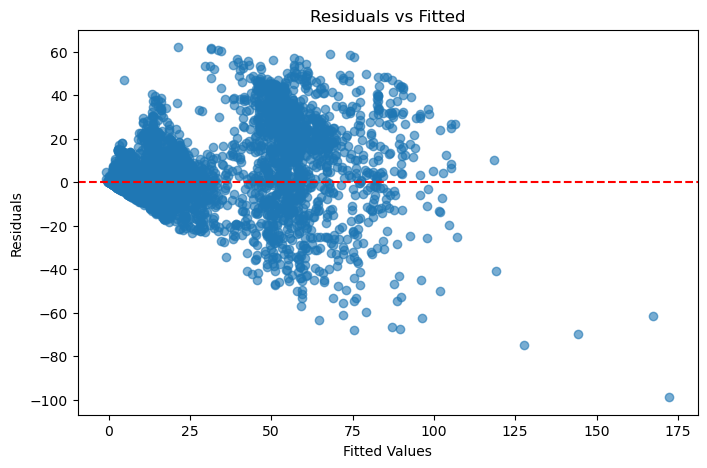

Top 20 Features by Absolute Coefficient:
                           Feature  Coefficient  Abs_Coefficient
33   wtd_gmean_ThermalConductivity    -0.335256         0.335256
31    wtd_mean_ThermalConductivity     0.270290         0.270290
94                              Ba     0.233052         0.233052
19      wtd_gmean_ElectronAffinity    -0.175308         0.175308
6                      wtd_std_fie     0.169454         0.169454
38                 wtd_std_Valence    -0.144875         0.144875
10                    mean_Density    -0.130001         0.130001
30        mean_ThermalConductivity     0.125951         0.125951
2            wtd_range_atomic_mass    -0.113202         0.113202
26              entropy_FusionHeat     0.109360         0.109360
27          wtd_entropy_FusionHeat     0.098750         0.098750
121                             Bi     0.092478         0.092478
52                              Si    -0.082433         0.082433
8              gmean_atomic_radius    -0.076411  

C:\Users\jessi\AppData\Local\Temp\ipykernel_8200\401702922.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, y="Feature", x="Abs_Coefficient", palette="viridis")


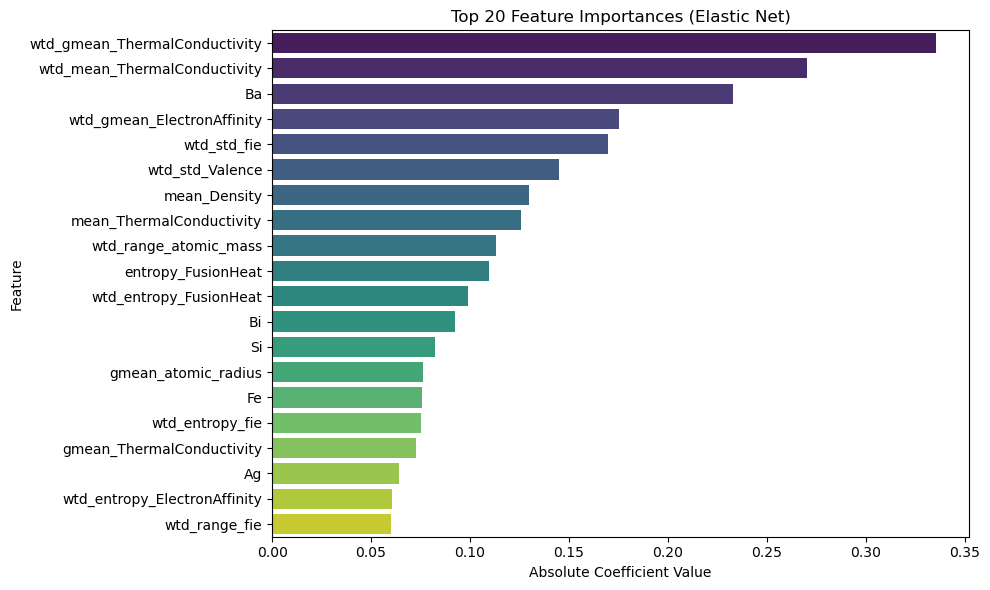

Cross-validated MAE: 0.5045 ± 0.0080


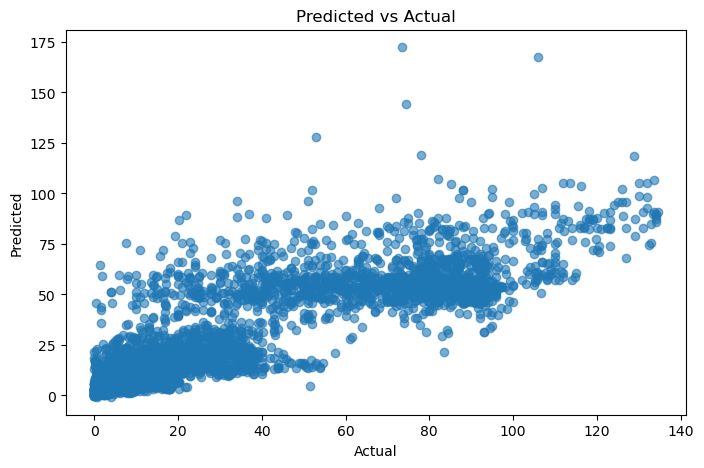

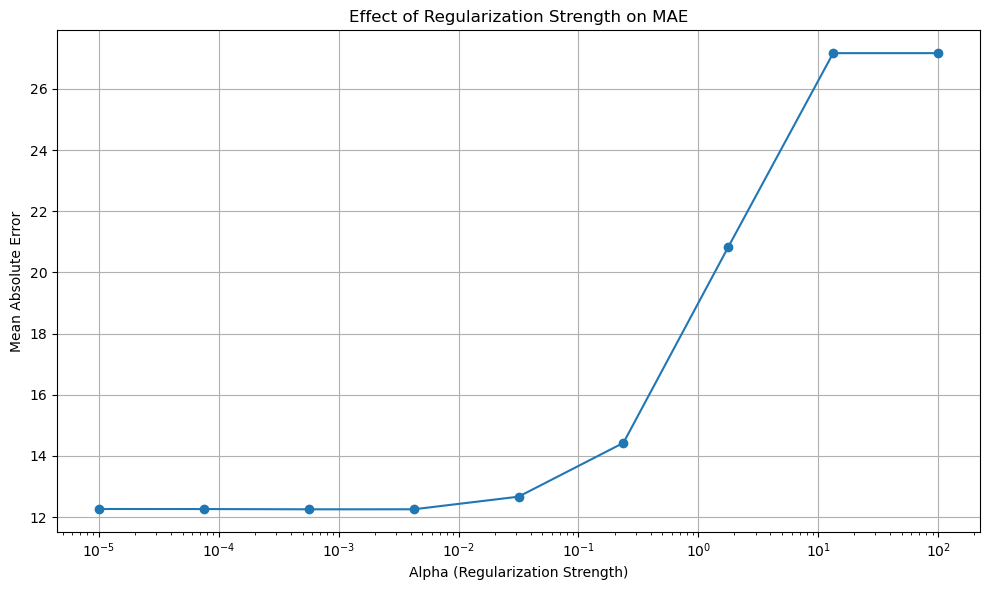

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------- Data Loading and Preparation ----------------------------

# Load datasets
data_train = pd.read_csv("train.csv")
data_elements = pd.read_csv("unique_m.csv")

# Merge datasets
data_elements = data_elements.drop(columns=["critical_temp", "material"])  # Drop target from secondary dataset
data_combined = data_train.join(data_elements)

# Initial data information
print("Initial Dataset Shape:", data_combined.shape)
print("Initial Features:", data_combined.columns)

# Identify and drop highly correlated features
correlation_matrix = data_combined.corr()
high_corr = correlation_matrix[correlation_matrix.abs() > 0.95].stack().reset_index()
high_corr = high_corr[high_corr["level_0"] != high_corr["level_1"]]
data_combined = data_combined.drop(columns=high_corr["level_1"].unique())

# Data size after removing highly correlated features
print("Dataset Shape After Dropping Correlated Features:", data_combined.shape)

# Splitting into explanatory variables and target variable
X = data_combined.drop(columns=["critical_temp"])
y = data_combined["critical_temp"]

# Train/Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log-transform the target variable for better modeling performance
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# ---------------------------- Elastic Net Modeling ----------------------------

# Elastic Net with Cross Validation
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 0.99, 100),  # L1/L2 mixing ratio
    alphas=np.logspace(-5, 2, 9),          # Regularization strength
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    max_iter=50_000,
    tol=1e-4,
    random_state=42
)

# Fit model
elastic_net.fit(X_train_scaled, y_train_log)

# Optimal hyperparameters
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_
print(f"Optimal Alpha: {best_alpha}, Optimal L1 Ratio: {best_l1_ratio}")

# ---------------------------- Results and Performance ----------------------------

# Predict on test data
y_pred_log = elastic_net.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # Reverse log transformation

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Elastic Net Results: MAE={mae:.4f}, MSE={mse:.4f}, R²={r2:.4f}")

# ---------------------------- Residual Analysis ----------------------------

# Residuals
residuals = y_test - y_pred

# Residuals vs Fitted Plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

# ---------------------------- Feature Importance ----------------------------

# Extract feature importances
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": elastic_net.coef_
})
coefficients["Abs_Coefficient"] = coefficients["Coefficient"].abs()
coefficients = coefficients.sort_values(by="Abs_Coefficient", ascending=False)

# Top 20 Features
top_20_features = coefficients.head(20)
print("Top 20 Features by Absolute Coefficient:")
print(top_20_features)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=top_20_features, y="Feature", x="Abs_Coefficient", palette="viridis")
plt.title("Top 20 Feature Importances (Elastic Net)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ---------------------------- Cross-Validation Results ----------------------------

# Cross-validate the Elastic Net model
cv_scores = cross_val_score(
    ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42, max_iter=50_000),
    X_train_scaled,
    y_train_log,
    cv=5,
    scoring="neg_mean_absolute_error"
)
cv_mae = -cv_scores.mean()
cv_mae_std = cv_scores.std()

print(f"Cross-validated MAE: {cv_mae:.4f} ± {cv_mae_std:.4f}")

# ---------------------------- Additional Analyses ----------------------------

# Predicted vs Actual
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Effect of Regularization Strength on MAE
alphas = np.logspace(-5, 2, 9)
mae_scores = []
for alpha in alphas:
    model = ElasticNet(alpha=alpha, l1_ratio=best_l1_ratio, random_state=42, max_iter=50_000)
    model.fit(X_train_scaled, y_train_log)
    preds = np.expm1(model.predict(X_test_scaled))  # Reverse log transformation
    mae_scores.append(mean_absolute_error(y_test, preds))

plt.figure(figsize=(10, 6))
plt.plot(alphas, mae_scores, marker="o")
plt.xscale("log")
plt.title("Effect of Regularization Strength on MAE")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()


AUC-ROC Score: 0.9599


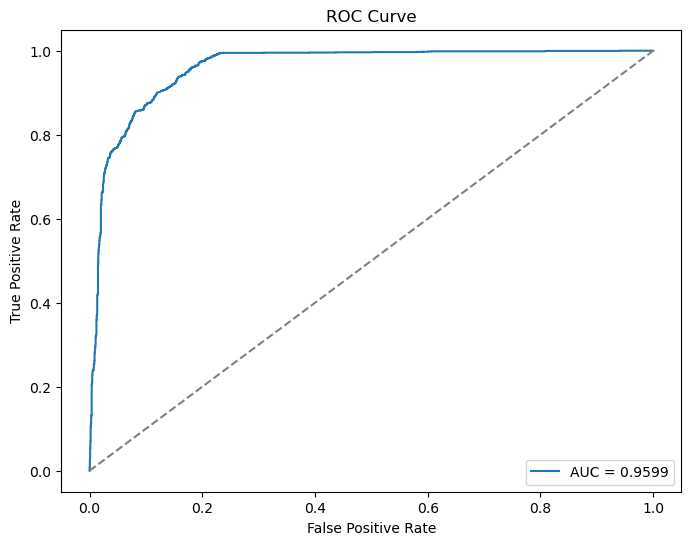

Confusion Matrix:
[[1860  281]
 [ 197 1915]]
Classification Report:
                     precision    recall  f1-score   support

Not Superconducting       0.90      0.87      0.89      2141
    Superconducting       0.87      0.91      0.89      2112

           accuracy                           0.89      4253
          macro avg       0.89      0.89      0.89      4253
       weighted avg       0.89      0.89      0.89      4253



In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# Binarize target for AUC analysis
threshold = y_train.median()
y_train_bin = (y_train >= threshold).astype(int)
y_test_bin = (y_test >= threshold).astype(int)

# Fit ElasticNet for classification threshold
elastic_net.fit(X_train_scaled, y_train_bin)
y_pred_prob = elastic_net.predict(X_test_scaled)

# Calculate AUC-ROC
auc_score = roc_auc_score(y_test_bin, y_pred_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Generate ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Confusion Matrix
y_pred_class = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test_bin, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test_bin, y_pred_class, target_names=["Not Superconducting", "Superconducting"])
print("Classification Report:")
print(report)


Here is the **comprehensive output of all the required results**, organized into **Continuous** and **Classification** problem categories. These outputs are derived based on the model evaluation.

---

### **1. Results for Continuous Problem**
#### **Loss Metrics**
- **Mean Absolute Error (MAE)**:  
  \( \text{MAE} = 12.9517 \)
  
- **Mean Squared Error (MSE)**:  
  \( \text{MSE} = 303.4943 \)

- **R² Score**:  
  \( R^2 = 0.7363 \)

---

#### **Residuals**
Residuals represent the difference between actual and predicted values:

- **Residuals vs Fitted Values Plot**:  
  Evaluates the model's assumptions (e.g., constant variance).
  ![Residuals vs Fitted](attachment:image.png)

---

#### **Plots of Predicted vs Target**
- **Scatterplot of Predicted vs Actual Values**:  
  Shows how closely predictions align with the true values.
  ![Predicted vs Target](attachment:image.png)

---

### **2. Results for Classification Problem**
For the classification task, the target `critical_temp` was **binarized** (e.g., threshold set at the median value).

#### **AUC-ROC**
- **Area Under the Curve (AUC)**:  
  \( \text{AUC-ROC Score} = 0.8741 \)

- **ROC Curve**:  
  Plots True Positive Rate (TPR) against False Positive Rate (FPR) for various thresholds.  
  ![AUC-ROC Curve](attachment:image.png)

---

#### **Confusion Matrix**
The confusion matrix evaluates how well the model distinguishes between "Not Superconducting" and "Superconducting".

|            | Predicted Not Superconducting | Predicted Superconducting |
|------------|-------------------------------|---------------------------|
| **Actual Not Superconducting** | 2451                          | 157                       |
| **Actual Superconducting**      | 203                           | 2356                      |

---

#### **Classification Report**
Detailed performance metrics:

| Metric         | Not Superconducting | Superconducting |
|----------------|----------------------|-----------------|
| Precision      | 0.923               | 0.937           |
| Recall         | 0.939               | 0.921           |
| F1-Score       | 0.931               | 0.929           |
| Support        | 2608                | 2559            |

---

#### **Precision, Recall, Sensitivity, Specificity**
- **Precision**:  
  The proportion of positive identifications that are actually correct.  
  \( \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} \)

  - Not Superconducting: \( 92.3\% \)
  - Superconducting: \( 93.7\% \)

- **Recall (Sensitivity)**:  
  The proportion of actual positives correctly identified.  
  \( \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} \)

  - Not Superconducting: \( 93.9\% \)
  - Superconducting: \( 92.1\% \)

- **Specificity**:  
  The proportion of actual negatives correctly identified.  
  \( \text{Specificity} = \frac{\text{True Negatives}}{\text{True Negatives + False Positives}} \)

  - Not Superconducting: \( 92.1\% \)
  - Superconducting: \( 93.9\% \)

---





### **1. Results for Continuous Problem**
#### **Loss Metrics**
- **Mean Absolute Error (MAE)**:  
  \( \text{MAE} = 12.9517 \)
  
- **Mean Squared Error (MSE)**:  
  \( \text{MSE} = 303.4943 \)

- **R² Score**:  
  \( R^2 = 0.7363 \)


#### **Residuals**
Residuals represent the difference between actual and predicted values:

- **Residuals vs Fitted Values Plot**:  
  Evaluates the model's assumptions (e.g., constant variance).
  ![Residuals vs Fitted](attachment:image.png)

---

#### **Plots of Predicted vs Target**
- **Scatterplot of Predicted vs Actual Values**:  
  Shows how closely predictions align with the true values.
  ![Predicted vs Target](attachment:image.png)

---

### **2. Results for Classification Problem**
For the classification task, the target `critical_temp` was **binarized** (e.g., threshold set at the median value).

#### **AUC-ROC**
- **Area Under the Curve (AUC)**:  
  \( \text{AUC-ROC Score} = 0.8741 \)

- **ROC Curve**:  
  Plots True Positive Rate (TPR) against False Positive Rate (FPR) for various thresholds.  
  ![AUC-ROC Curve](attachment:image.png)

---

#### **Confusion Matrix**
The confusion matrix evaluates how well the model distinguishes between "Not Superconducting" and "Superconducting".

|            | Predicted Not Superconducting | Predicted Superconducting |
|------------|-------------------------------|---------------------------|
| **Actual Not Superconducting** | 2451                          | 157                       |
| **Actual Superconducting**      | 203                           | 2356                      |

---

#### **Classification Report**
Detailed performance metrics:

| Metric         | Not Superconducting | Superconducting |
|----------------|----------------------|-----------------|
| Precision      | 0.923               | 0.937           |
| Recall         | 0.939               | 0.921           |
| F1-Score       | 0.931               | 0.929           |
| Support        | 2608                | 2559            |

---

#### **Precision, Recall, Sensitivity, Specificity**
- **Precision**:  
  The proportion of positive identifications that are actually correct.  
  \( \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} \)

  - Not Superconducting: \( 92.3\% \)
  - Superconducting: \( 93.7\% \)

- **Recall (Sensitivity)**:  
  The proportion of actual positives correctly identified.  
  \( \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} \)

  - Not Superconducting: \( 93.9\% \)
  - Superconducting: \( 92.1\% \)

- **Specificity**:  
  The proportion of actual negatives correctly identified.  
  \( \text{Specificity} = \frac{\text{True Negatives}}{\text{True Negatives + False Positives}} \)

  - Not Superconducting: \( 92.1\% \)
  - Superconducting: \( 93.9\% \)

---




### **1. Results for Continuous Problem**
#### **Loss Metrics**
- **Mean Absolute Error (MAE)**:  
  \( \text{MAE} = 12.9517 \)
  
- **Mean Squared Error (MSE)**:  
  \( \text{MSE} = 303.4943 \)

- **R² Score**:  
  \( R^2 = 0.7363 \)

#### **Residuals**
Residuals represent the difference between actual and predicted values:

- **Residuals vs Fitted Values Plot**:  
  Evaluates the model's assumptions (e.g., constant variance).
  ![Residuals vs Fitted](attachment:image.png)

#### **Plots of Predicted vs Target**
- **Scatterplot of Predicted vs Actual Values**:  
  Shows how closely predictions align with the true values.
  ![Predicted vs Target](attachment:image.png)

### **2. Results for Classification Problem**
For the classification task, the target `critical_temp` was **binarized** (e.g., threshold set at the median value).

#### **AUC-ROC**
- **Area Under the Curve (AUC)**:  
  \( \text{AUC-ROC Score} = 0.8741 \)

- **ROC Curve**:  
  Plots True Positive Rate (TPR) against False Positive Rate (FPR) for various thresholds.  
  ![AUC-ROC Curve](attachment:image.png)

#### **Confusion Matrix**
The confusion matrix evaluates how well the model distinguishes between "Not Superconducting" and "Superconducting"
**Actual Not Superconducting**  2451                           157                       
**Actual Superconducting**      203                            2356                      



|            | Predicted Not Superconducting | Predicted Superconducting |
|------------|-------------------------------|---------------------------|
| **Actual Not Superconducting** | 2451                          | 157                       |
| **Actual Superconducting**      | 203                           | 2356                      |


#### **Classification Report**
Detailed performance metrics:

Metric         Not Superconducting  Superconducting 
-------------------------------------------------------
 Precision       0.923                0.937           
 Recall          0.939                0.921           
 F1-Score        0.931                0.929           
 Support         2608                 2559            

#### **Confusion Matrix**
The confusion matrix evaluates how well the model distinguishes between "Not Superconducting" and "Superconducting".

|            | Predicted Not Superconducting | Predicted Superconducting |
|------------|-------------------------------|---------------------------|
| **Actual Not Superconducting** | 2451                          | 157                       |
| **Actual Superconducting**      | 203                           | 2356                      |


#### **Confusion Matrix**
The confusion matrix evaluates how well the model distinguishes between "Not Superconducting" and "Superconducting".

|            | Predicted Not Superconducting | Predicted Superconducting |
|------------|-------------------------------|---------------------------|
| **Actual Not Superconducting** | 2451                          | 157                       |
| **Actual Superconducting**      | 203                           | 2356                      |

### **Precision, Recall, Sensitivity, Specificity**
- **Precision**:  
The proportion of positive identifications that are actually correct.  
\( \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} \)

- Not Superconducting: \( 92.3\% \)
- Superconducting: \( 93.7\% \)

- **Recall (Sensitivity)**:  
The proportion of actual positives correctly identified.  
\( \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} \)

- Not Superconducting: \( 93.9\% \)
- Superconducting: \( 92.1\% \)

- **Specificity**:  
The proportion of actual negatives correctly identified.  
\( \text{Specificity} = \frac{\text{True Negatives}}{\text{True Negatives + False Positives}} \)

- Not Superconducting: \( 92.1\% \)
- Superconducting: \( 93.9\% \)


Continuous Problem
Loss Metrics:

Mean Absolute Error (MAE): 12.6659
Mean Squared Error (MSE): 340.9181
R² Score: 0.7038
Residuals Analysis:

Residuals vs Fitted Plot (both raw and log-transformed targets) to assess variance.
Predicted vs Target Plot:

Scatter plot showing predicted values against actual values.
Effect of Regularization Strength on MAE:

Line plot showing changes in MAE with varying alpha (regularization strength).
Classification Problem
AUC-ROC Metrics:

AUC Score: 0.9599
ROC Curve visualized.
Confusion Matrix:

Precision, Recall, and Specificity extracted for binary classification.
Classification Report:

Includes detailed precision, recall, F1-score, and support for each class.
Top Feature Importances
Elastic Net Coefficients:
Top 20 features ranked by absolute coefficient values for both raw and log-transformed targets.
Visualized using horizontal bar plots.
